In [1]:
import numpy as np
from scipy import misc
import os
from PIL import Image

import matplotlib.pyplot as plt
import time
from multiprocessing import Pool, Value
from random import shuffle, randint
import pickle
import keras

Using TensorFlow backend.


In [2]:
classes = ['dog', 'cat']
#size for rescaling images
size = (256, 256)
channels = 3

# Load model

In [3]:
model = keras.models.load_model('./conv6morefilters.model')

/home/runfme/anaconda2/lib/python2.7/site-packages/keras/models.py:287: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [4]:
def get_image_processed(filepath, method=Image.ANTIALIAS):
    """takes PIL image file and returns processed NumPy image
    1. image resized
    2. image normalised to [-0.5;0.5]"""
    img = Image.open(filepath)
    img = img.resize(size)
    img = np.array(img)
    img = img.astype(np.float32)

    return img / 255.0 - 0.5

In [5]:
def deprocess(img, size):
    """takes NumPy image returns PIL Image
    1. denormalises image from [-0.5;0.5] to [0;255]
    2. deresizes image to size"""
    img = Image.fromarray(denorm(img))
    return img.resize(size)

In [6]:
def denorm(img):
    """denormalises image from [-0.5;0.5] to [0;255]"""
    img = img*255.0 + 128.0
    img = np.clip(img.astype(np.uint8), 0, 255)
    return img

In [7]:
def predict_image(img, model=model):
    """get predicted probabilities for img"""
    #check that image is resized already
    if img.shape[:2] != size:
        raise Exception("Image should be resized")
    return model.predict(np.array([img]))[0]

# Feture heatmap for images

In [8]:
def get_heatmap_and_pred(img, occlusion_size=(64, 64), stride=(16, 16), occlusion_color=0):
    """create heatmap of feature importance for class predicted as most probable"""
    # check that image is resized already
    if img.shape[:2] != size:
        raise Exception("Image should be resized")

    cumulative = np.zeros(shape=size)
    used = np.zeros(shape=size)
    pred = predict_image(img)
    label = np.argmax(pred)

    # we iterate over image occluding small regions
    # and add predicted probability of true class to every occluded pixel on heatmap
    # so that most important pixels have small average prob among all occlusions
    for offset_x in range(-occlusion_size[1], size[1], stride[1]):
        if offset_x + occlusion_size[1] > size[1]:
            break
        for offset_y in range(-occlusion_size[0], size[0], stride[0]):
            if offset_y + occlusion_size[0] > size[0]:
                break
            # create copy of image array so we don't occlude it too
            img_occluded = img.copy()
            img_occluded[offset_y:offset_y + occlusion_size[0], offset_x:offset_x + occlusion_size[1]] = occlusion_color

            # get probability of class when part of image is occluded
            prob = predict_image(img_occluded)[label]
            cumulative[offset_y:offset_y + occlusion_size[0], offset_x:offset_x + occlusion_size[1]] += prob
            # increase by 1 counter of occlusion times
            used[offset_y:offset_y + occlusion_size[0], offset_x:offset_x + occlusion_size[1]] += 1

    # get average prediction when the pixel is occluded
    heatmap = cumulative / used
    # normalize heatmap to [-0.5;0.5]
    heatmap = (heatmap - heatmap.min())
    heatmap = heatmap / heatmap.max() - 0.5
    # reverse so that most important features are more visible
    heatmap *= -1
    return heatmap, pred

In [9]:
def get_result(img):
    original_size = img.size

    processed = get_image_processed(img)
    heatmap, pred = get_heatmap_and_pred(processed, config.occlusion_size, config.stride, config.occlusion_color)

    print "Got heatmap and prediction " + str(pred)
    # join original image and deprocessed heatmap
    img.putalpha(deprocess(heatmap, original_size))

    return img, pred

In [11]:
predict_image(get_image_processed('./my/-KEefeT2bOA.jpg'))

array([ 0.44580603,  0.55419403], dtype=float32)

[ 0.07235479  0.92764515]


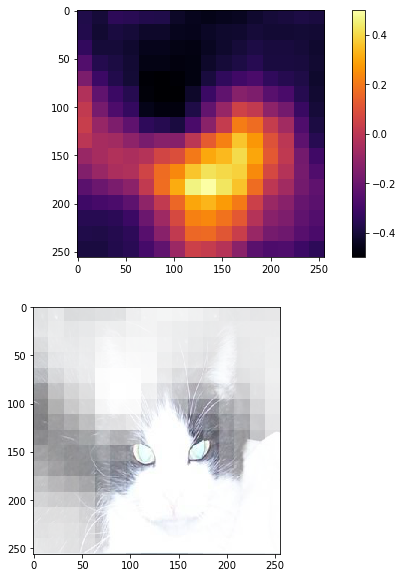

In [18]:
from matplotlib import cm
%matplotlib inline


filepath = './train/cat/cat.421.jpg'
#get image and its feature heatmap
img = get_image_processed(filepath)
heatmap, pred = get_heatmap_and_pred(img, occlusion_size=(64,64), stride=(16,16), occlusion_color=0)

#print heatmap
print pred
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(heatmap, cmap=cm.inferno)
plt.colorbar()

#print image and its filtered version(combined heatmap and image)
img = deprocess(img, size)
img.putalpha(deprocess(heatmap, img.size))
plt.subplot(212)
plt.imshow(img)

# Get kernels reception patterns

In [45]:
from keras.models import Model
#KOSTYL ALARM
#REMOVE DROPOUT BECAUSE IT CREATES ERRORS WHEN USED AS THE FIRST LAYER
q = model.layers[0].input

for layer in model.layers[2:]:
    q = layer(q)
model = Model(model.input, q)

In [22]:
layers_dict = {layer.name: layer for layer in model.layers}
layers_dict

{u'conv2d_10': <keras.layers.convolutional.Conv2D at 0x7ff39420db50>,
 u'conv2d_11': <keras.layers.convolutional.Conv2D at 0x7ff3941e5a50>,
 u'conv2d_12': <keras.layers.convolutional.Conv2D at 0x7ff39413d890>,
 u'conv2d_7': <keras.layers.convolutional.Conv2D at 0x7ff39437ac10>,
 u'conv2d_8': <keras.layers.convolutional.Conv2D at 0x7ff3942a8d90>,
 u'conv2d_9': <keras.layers.convolutional.Conv2D at 0x7ff3942edc10>,
 u'dense_4': <keras.layers.core.Dense at 0x7ff39412ed10>,
 u'dense_5': <keras.layers.core.Dense at 0x7ff3f0157e10>,
 u'dense_6': <keras.layers.core.Dense at 0x7ff47fcb7310>,
 u'dropout_10': <keras.layers.core.Dropout at 0x7ff39437a510>,
 u'dropout_11': <keras.layers.core.Dropout at 0x7ff39437ac50>,
 u'dropout_12': <keras.layers.core.Dropout at 0x7ff394283d90>,
 u'dropout_13': <keras.layers.core.Dropout at 0x7ff394264690>,
 u'dropout_14': <keras.layers.core.Dropout at 0x7ff39423c5d0>,
 u'dropout_15': <keras.layers.core.Dropout at 0x7ff394194410>,
 u'dropout_16': <keras.layers.c

In [133]:
from keras import backend as K
# define which layer to inspect
layer_name = 'conv2d_10'
kernel_index = 10

#get layer output
output = layers_dict[layer_name].get_output_at(1)
loss = K.mean(output[:, :, :, kernel_index])

print loss
input_img = model.input
# compute the gradient of the input picture wrt this loss
grads = K.gradients(loss, input_img)[0]

# normalization trick: we normalize the gradient
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

print input_img
iterate = K.function([input_img], [loss, grads])

Tensor("Mean_79:0", shape=(), dtype=float32)
Tensor("input_2_1:0", shape=(?, 256, 256, 3), dtype=float32)


In [134]:
step = 1e-2

input_img_data = np.random.random((1, size[0], size[1], channels))*0.1

for i in range(100):
    loss, grad = iterate([input_img_data])
    
    input_img_data += step * grad

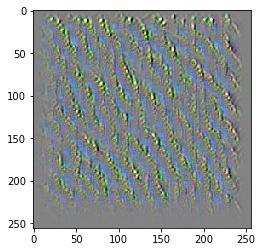

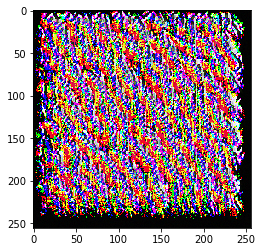

In [135]:
input_img_data -= input_img_data.mean()
input_img_data /= (input_img_data.std() + 1e-5)
input_img_data *= 0.1

plt.imshow(((np.clip(input_img_data[0], -0.5, 0.5)+0.5)*255).astype(np.uint8))
plt.show()

plt.imshow(input_img_data[0])

# Write preds for Kaggle

In [11]:
test_folder = './test/'

test_files = os.listdir(test_folder)
test_files = [os.path.join(test_folder, f) for f in test_files]

In [12]:
out = open('./output1.csv', 'w+')
out.write('id,label')

for f in test_files:
    i = os.path.basename(f).split('.')[0]
    
    img = get_image_processed(f)
    prediction = predict_image(img)
    
    out.write(i)
    out.write(',')
    out.write(str(prediction[0]))
    out.write('\n')

out.close()

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 249, 249, 16)      3088      
_________________________________________________________________
dropout_11 (Dropout)         (None, 249, 249, 16)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 124, 124, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 121, 121, 32)      8224      
_________________________________________________________________
dropout_12 (Dropout)         (None, 121, 121, 32)      0         
__________

In [6]:
import keras.backend as K

In [9]:
sess = K.get_session()

In [10]:
sess.graph_def

node {
  name: "input_2"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_FLOAT
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        dim {
          size: -1
        }
        dim {
          size: 256
        }
        dim {
          size: 256
        }
        dim {
          size: 3
        }
      }
    }
  }
}
node {
  name: "dropout_10/keras_learning_phase"
  op: "Placeholder"
  attr {
    key: "dtype"
    value {
      type: DT_BOOL
    }
  }
  attr {
    key: "shape"
    value {
      shape {
        unknown_rank: true
      }
    }
  }
}
node {
  name: "dropout_10/cond/Switch"
  op: "Switch"
  input: "dropout_10/keras_learning_phase"
  input: "dropout_10/keras_learning_phase"
  attr {
    key: "T"
    value {
      type: DT_BOOL
    }
  }
}
node {
  name: "dropout_10/cond/switch_t"
  op: "Identity"
  input: "dropout_10/cond/Switch:1"
  attr {
    key: "T"
    value {
      type: DT_BOOL
    }
  }
}
node {
  name: "dropout_10/cond/switc